In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (9, 6)

from ofdm_lib.BitArray import read_file
from ofdm_lib.map_demap import mapping, demapping, get_constellation_order
from ofdm_lib.ofdm_multiplex_demultiplex import OfdmConfig, multiplex_to_ofdm, demultiplex_from_ofdm
from ofdm_lib.randomizer import randomize
from ofdm_lib.Utility import calc_ber
from ofdm_lib.channel import ChannelConfig, agwn_cmplx, freq_shift, time_delay, multi_path

from transmission import signal_tx_operation, signal_channel_propagation, signal_rx_operation, signal_rx_rough_correction

In [5]:
# << configuration >> ----------------------------------------------------
#constellation = "BPSK"
#constellation = "QPSK"
constellation = "16-QAM"

ofdm_cfg = OfdmConfig(
    n_fft=1024,
    n_carrier=400,
    t_guard_div=8,
    frame_sz=300,
    pilot_percent=0.1,
    pilot_amp_r=(4/3),
    constellation=constellation
)

use_randomize = True
rnd_init_state = [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

chan_cfg = ChannelConfig(
    snr=1000,
    freq_shift=0.2/ofdm_cfg.n_fft,  # from (-30 ... 30)/n_fft
    time_delay=0,
    multipath=[(0, 1), (1, 0.3)]#, (10, 0.3)]
)

# << read data to transmit >> --------------------------------------------
QAM_cells = ofdm_cfg.data_cnt * ofdm_cfg.frame_sz
buffer_sz_bits = QAM_cells * get_constellation_order(constellation)
data_file_name = 'data/War_and_Peace.doc'
input_bit_buffer = read_file(data_file_name, buffer_sz_bits)
# -------------------------------------------------------------------------

In [3]:
#np.random.seed(1232413712  )
#chan_cfg.snr = 24
#tx_out = signal_tx_operation(input_bit_buffer, ofdm_cfg, use_randomize, rnd_init_state)
#ch_out = signal_channel_propagation(tx_out, chan_cfg)
#correction_out, corr, tg_pos, fo = signal_rx_rough_correction(ch_out, ofdm_cfg)
#print("tg_pos={}".format(tg_pos))
#print('should be {:.4f}'.format(2*np.pi*(128-tg_pos)/1024))
#out_bits, ofdm_spec = signal_rx_operation(correction_out, ofdm_cfg, use_randomize, rnd_init_state, interp_kind='linear')
#print()
#print(calc_ber(input_bit_buffer, out_bits))

In [4]:
chan_cfg.snr=1000

tx_out = signal_tx_operation(input_bit_buffer, ofdm_cfg, use_randomize, rnd_init_state)
ch_out = signal_channel_propagation(tx_out, chan_cfg)
correction_out, corr, tg_pos, fo = signal_rx_rough_correction(ch_out, ofdm_cfg)
iq, ofdm_spec = demultiplex_from_ofdm(correction_out, ofdm_cfg, interp_kind='cubic')
#out_bits, ofdm_spec = signal_rx_operation(correction_out, ofdm_cfg, use_randomize, rnd_init_state, interp_kind=None)

<IPython.core.display.Javascript object>


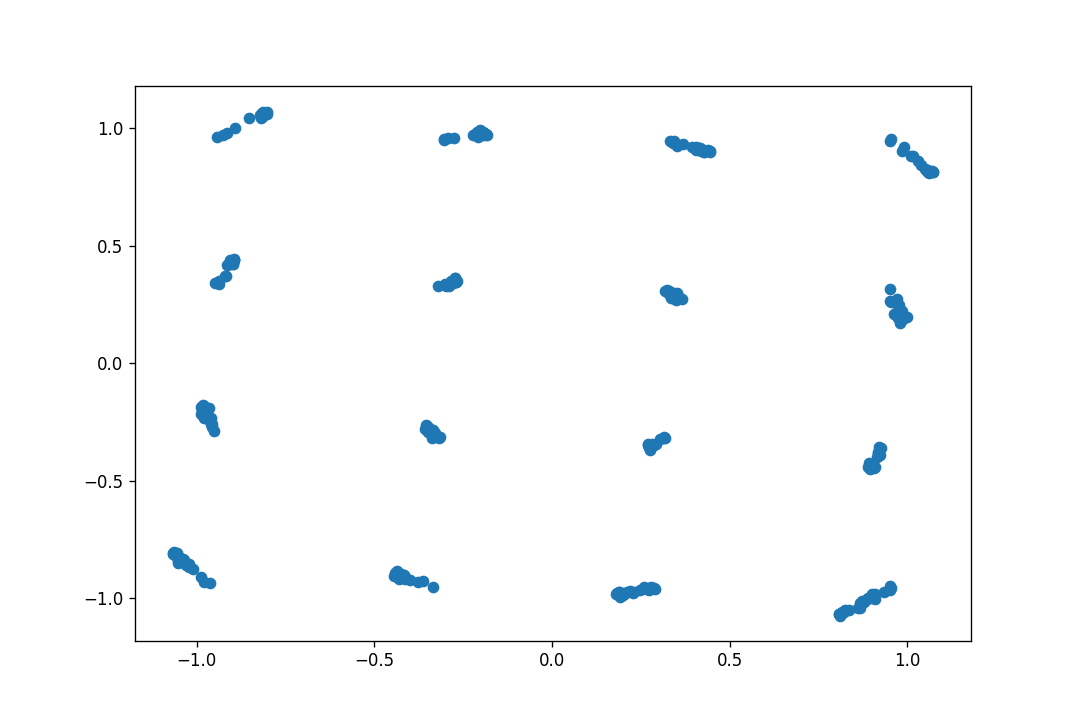

In [5]:
%matplotlib notebook
plt.scatter(iq.real[:300], iq.imag[:300])

<IPython.core.display.Javascript object>


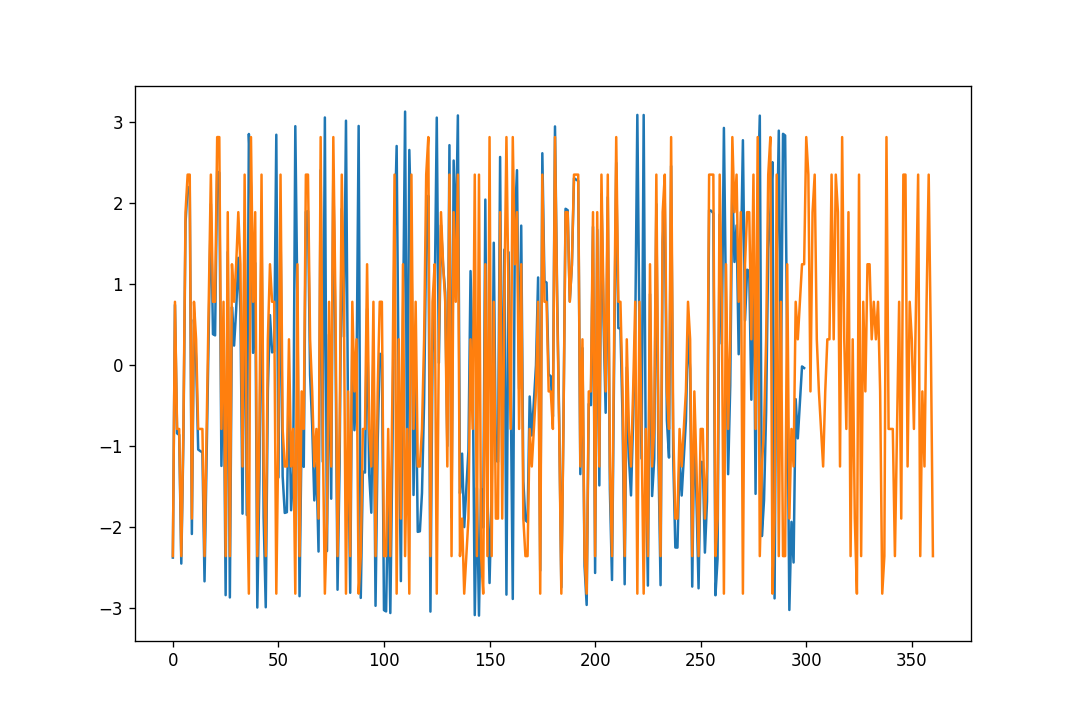

In [17]:
%matplotlib notebook
plt.plot(np.angle(iq[:300]))
plt.plot(np.angle(np.fft.fft(tx_out[ofdm_cfg.t_guard: ofdm_cfg.t_sym]))[ofdm_cfg.data_ind])

<IPython.core.display.Javascript object>


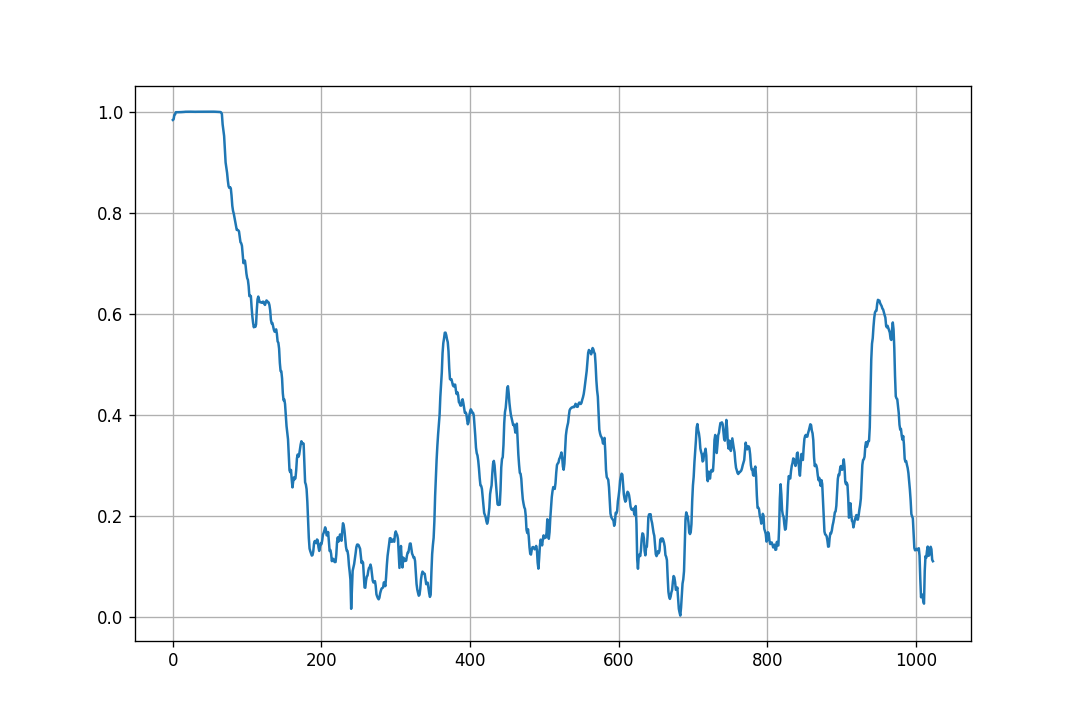

In [5]:
%matplotlib notebook
plt.plot(np.abs(corr))
plt.grid(True)


<IPython.core.display.Javascript object>


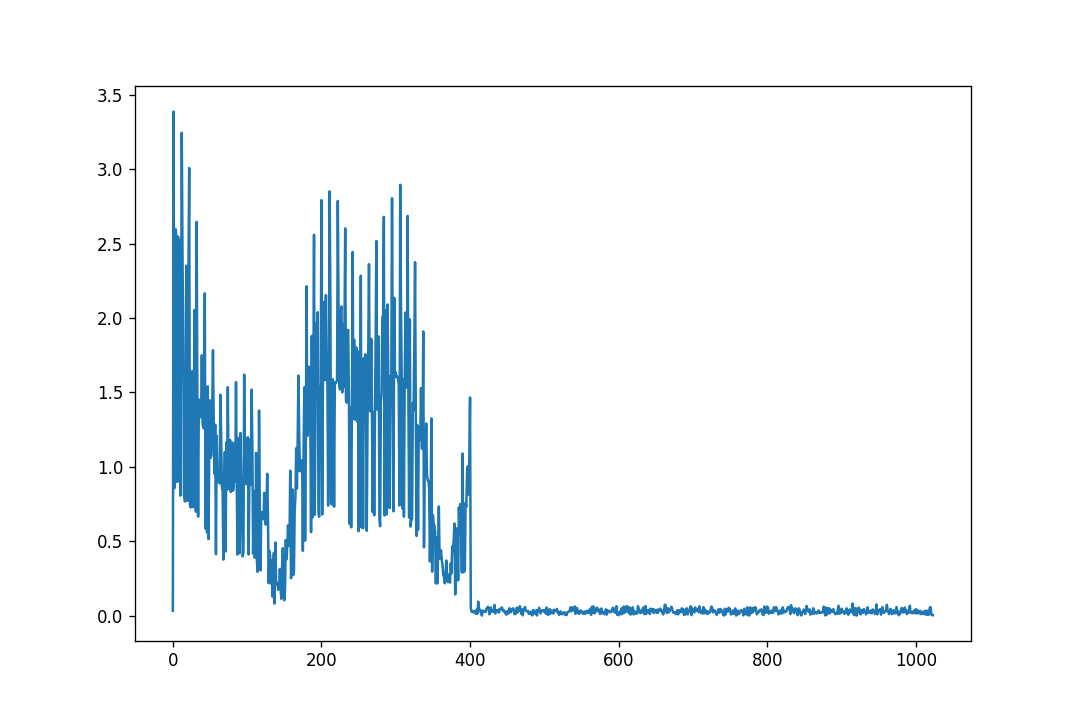

In [65]:
%matplotlib notebook

plt.plot(np.abs(ofdm_spec[0]))

# different interpolation comparison

# current problem: we are mostly aiming to lower part of guard that's bad need to go to the middle

In [10]:
0.3777*1024/(2*np.pi)

61.55552973394828

In [7]:
snr_list = np.arange(0, 21, 4)
interp_kinds = ['linear', 'quadratic', 'cubic'] #["linear", "quadratic", "cubic", None]
ber = {}
np.random.seed(1)
for interp_kind in interp_kinds:
    print("testing: {}".format(interp_kind))
    ber[interp_kind] = []
    for snr in snr_list:
        ber[interp_kind].append(0)
        chan_cfg.snr=snr

        tx_out = signal_tx_operation(input_bit_buffer, ofdm_cfg, use_randomize, rnd_init_state)
        ch_out = signal_channel_propagation(tx_out, chan_cfg)
        correction_out, corr, tg_pos, fo = signal_rx_rough_correction(ch_out, ofdm_cfg)
        out_bits, ofdm_spec = signal_rx_operation(correction_out, 
                                                  ofdm_cfg, use_randomize, rnd_init_state, 
                                                  interp_kind=interp_kind)
        ber[interp_kind][-1] += calc_ber(input_bit_buffer, out_bits)
        
        print("snr={}, ber={:.3f}, fr_off={:.4e}, fr_off_est={:.4e}, 128-tg_pos={}, tg_corr={}".format(
            snr, ber[interp_kind][-1], chan_cfg.freq_shift, fo, 128-tg_pos, 0
        ))

testing: linear
snr=0, ber=0.311, fr_off=1.9531e-04, fr_off_est=1.6672e-04, 128-tg_pos=47, tg_corr=0
snr=4, ber=0.251, fr_off=1.9531e-04, fr_off_est=1.9436e-04, 128-tg_pos=54, tg_corr=0
snr=8, ber=0.168, fr_off=1.9531e-04, fr_off_est=1.9526e-04, 128-tg_pos=56, tg_corr=0
snr=12, ber=0.060, fr_off=1.9531e-04, fr_off_est=1.9744e-04, 128-tg_pos=53, tg_corr=0
snr=16, ber=0.007, fr_off=1.9531e-04, fr_off_est=2.0027e-04, 128-tg_pos=52, tg_corr=0
snr=20, ber=0.000, fr_off=1.9531e-04, fr_off_est=1.9906e-04, 128-tg_pos=51, tg_corr=0
testing: quadratic
snr=0, ber=0.281, fr_off=1.9531e-04, fr_off_est=2.2078e-04, 128-tg_pos=42, tg_corr=0
snr=4, ber=0.193, fr_off=1.9531e-04, fr_off_est=1.7545e-04, 128-tg_pos=54, tg_corr=0
snr=8, ber=0.097, fr_off=1.9531e-04, fr_off_est=2.0337e-04, 128-tg_pos=51, tg_corr=0
snr=12, ber=0.025, fr_off=1.9531e-04, fr_off_est=1.9371e-04, 128-tg_pos=51, tg_corr=0
snr=16, ber=0.003, fr_off=1.9531e-04, fr_off_est=1.9596e-04, 128-tg_pos=51, tg_corr=0
snr=20, ber=0.000, fr_off

In [60]:
out_bits.data[out_bits.size()-10:out_bits.size()-1]

array([0, 0, 1, 1, 1, 0, 0, 1, 0])

In [61]:
input_bit_buffer.data[input_bit_buffer.size()-10 : input_bit_buffer.size()-1]

array([1, 0, 0, 1, 1, 0, 0, 1, 0])

<IPython.core.display.Javascript object>


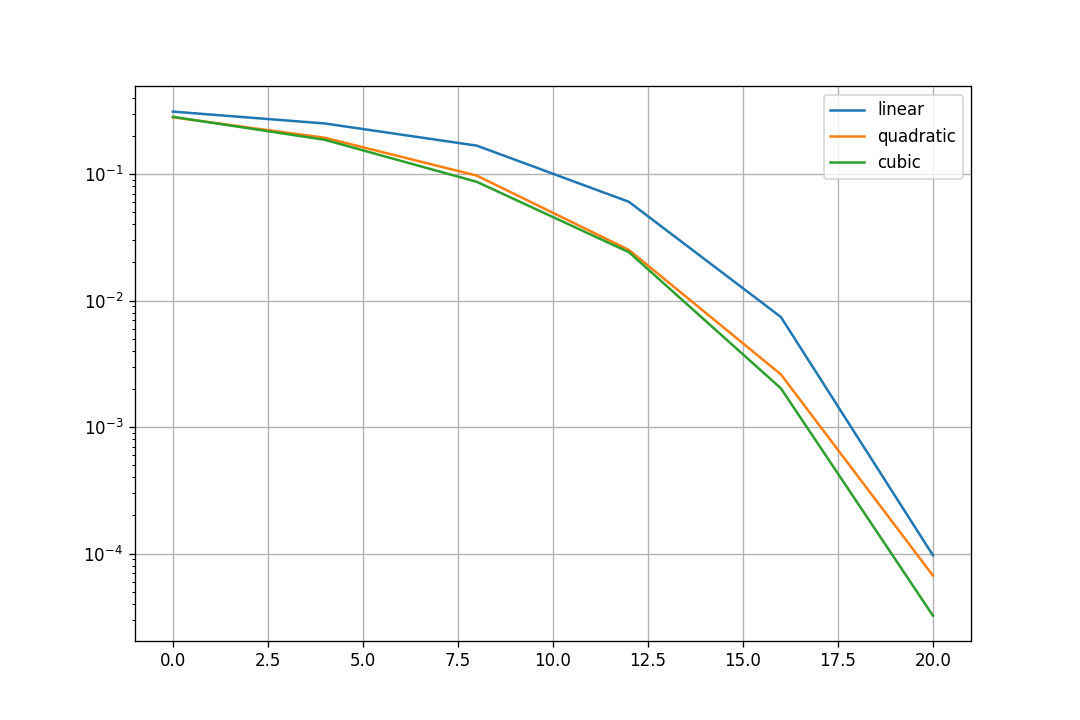

In [8]:
%matplotlib notebook

plt.yscale("log")

for kind in interp_kinds:
    plt.plot(snr_list, ber[kind])

plt.legend(["None" if s is None else s for s in interp_kinds])
plt.grid(True)